In [99]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
def load_skeleton_data(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.json')]
    data = []
    for f in files:
        with open(os.path.join(directory, f), 'r') as file:
            data.append(json.load(file))
    return data, files
dataset_dir = '../datasets/mm-fit/skeleton/json_raw/'
directories = []
with os.scandir(dataset_dir) as entries:
    for entry in entries:
        if entry.is_dir():
            directories.append(entry.name)

# samples = []
# files = []
# # do we really need to load this?? there is another process directory function
# for dir_name in directories:
#     data, file = load_skeleton_data(dataset_dir + dir_name)
#     samples.append(data)
#     files.append(file)
#     print(f"Loaded {len(data)} {dir_name} files.")


In [101]:
def get_subject_id(filename):
    return filename.split('_')[0]

def skeleton_to_numpy(frames):
    """Converts list of frames to a numpy array of shape (num_frames, 33, 4)"""
    num_frames = len(frames)
    arr = np.zeros((num_frames, 33, 4))
    for i, frame in enumerate(frames):
        for j, lm in enumerate(frame['landmarks']):
            arr[i, j, 0] = lm['x']
            arr[i, j, 1] = lm['y']
            arr[i, j, 2] = lm['z']
            arr[i, j, 3] = lm['visibility']
    return arr

def smooth_skeleton(skeleton_arr, window_size=5): # test without this
    """
    Applies moving average smoothing to (num_frames, 33, 4) array
    """
    smoothed = skeleton_arr.copy()
    num_frames = skeleton_arr.shape[0]
    if num_frames < window_size:
        return smoothed
        
    for i in range(33): # Each landmark
        for j in range(3): # x, y, z
            smoothed[:, i, j] = pd.Series(skeleton_arr[:, i, j]).rolling(window=window_size, center=True, min_periods=1).mean()
            
    return smoothed

def normalize_skeleton(skeleton_arr): # do we really need normalization if we are extracting angles anyway??
    """
    Normalizes a skeleton array of shape (num_frames, 33, 4).
    1. Spatial: Midpoint between hips at (0,0,0)
    2. Scale: Distance between shoulders = 1
    """
    normalized = skeleton_arr.copy()
    
    for i in range(len(normalized)):
        # Landmark 23: Left Hip, 24: Right Hip
        left_hip = normalized[i, 23, :3]
        right_hip = normalized[i, 24, :3] # what if the hip is not visible? this will break!!
        hip_center = (left_hip + right_hip) / 2.0
        
        # Spatial Normalization
        normalized[i, :, :3] -= hip_center
        
        # Scale Normalization
        # Landmark 11: Left Shoulder, 12: Right Shoulder
        left_sh = normalized[i, 11, :3]
        right_sh = normalized[i, 12, :3]
        shoulder_dist = np.linalg.norm(left_sh - right_sh)
        
        if shoulder_dist > 0:
            normalized[i, :, :3] /= shoulder_dist
            
    return normalized

In [102]:
def calculate_angle(a, b, c):
    """Calculates the angle abc in degrees"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b
    
    # Add epsilon to avoid division by zero
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    
    return np.degrees(angle)

def extract_features_from_frame(frame_lm): # note: the hip must be visible for this function to extract features
    """
    Extracts features from a single frame (33, 4)
    """
    # Key landmark indices
    L_SHOULDER, R_SHOULDER = 11, 12
    L_ELBOW, R_ELBOW = 13, 14
    L_WRIST, R_WRIST = 15, 16
    L_HIP, R_HIP = 23, 24
    
    # Angles
    l_elbow_angle = calculate_angle(frame_lm[L_SHOULDER, :3], frame_lm[L_ELBOW, :3], frame_lm[L_WRIST, :3])
    r_elbow_angle = calculate_angle(frame_lm[R_SHOULDER, :3], frame_lm[R_ELBOW, :3], frame_lm[R_WRIST, :3])
    
    l_shoulder_angle = calculate_angle(frame_lm[L_HIP, :3], frame_lm[L_SHOULDER, :3], frame_lm[L_ELBOW, :3])
    r_shoulder_angle = calculate_angle(frame_lm[R_HIP, :3], frame_lm[R_SHOULDER, :3], frame_lm[R_ELBOW, :3])
    
    # Vertical distances (relative to shoulder)
    l_wrist_y_rel = frame_lm[L_WRIST, 1] - frame_lm[L_SHOULDER, 1]
    r_wrist_y_rel = frame_lm[R_WRIST, 1] - frame_lm[R_SHOULDER, 1]
    
    return [l_elbow_angle, r_elbow_angle, l_shoulder_angle, r_shoulder_angle, l_wrist_y_rel, r_wrist_y_rel]


In [103]:
all_data = []

def process_directory(directory, label):
    files = [f for f in os.listdir(directory) if f.endswith('.json')]
    for f in files:
        subject_id = get_subject_id(f)
        with open(os.path.join(directory, f), 'r') as file:
            frames = json.load(file)
            skeleton_arr = skeleton_to_numpy(frames)
            
            # Apply smoothing before normalization
            smoothed_arr = smooth_skeleton(skeleton_arr, window_size=5)
            normalized_arr = normalize_skeleton(smoothed_arr)
            
            for i in range(len(normalized_arr)):
                features = extract_features_from_frame(normalized_arr[i])
                data_point = {
                    'l_elbow_angle': features[0],
                    'r_elbow_angle': features[1],
                    'l_shoulder_angle': features[2],
                    'r_shoulder_angle': features[3],
                    'l_wrist_y_rel': features[4],
                    'r_wrist_y_rel': features[5],
                    'label': label,
                    'subject': subject_id,
                    'file': f,
                    'frame': i
                }
                all_data.append(data_point)

for i, dir_name in enumerate(directories):
    process_directory(dataset_dir + dir_name, i)

df = pd.DataFrame(all_data)
print(f"Total frames: {len(df)}")
df.head()


Total frames: 42868


,l_elbow_angle,r_elbow_angle,l_shoulder_angle,r_shoulder_angle,l_wrist_y_rel,r_wrist_y_rel,label,subject,file,frame
0,129.284131,136.093717,11.353927,19.455331,2.626538,2.577977,0,w00,w00_rgb_bicep_curls_1_skeleton.json,0
1,130.505624,135.830803,11.892974,19.235872,2.636417,2.558470,0,w00,w00_rgb_bicep_curls_1_skeleton.json,1
2,130.930329,134.843033,12.141835,18.852852,2.643452,2.526781,0,w00,w00_rgb_bicep_curls_1_skeleton.json,2
3,132.514309,133.044071,12.420967,23.482147,2.655936,2.408678,0,w00,w00_rgb_bicep_curls_1_skeleton.json,3
4,133.399178,133.260798,12.297367,27.920959,2.662916,2.281954,0,w00,w00_rgb_bicep_curls_1_skeleton.json,4


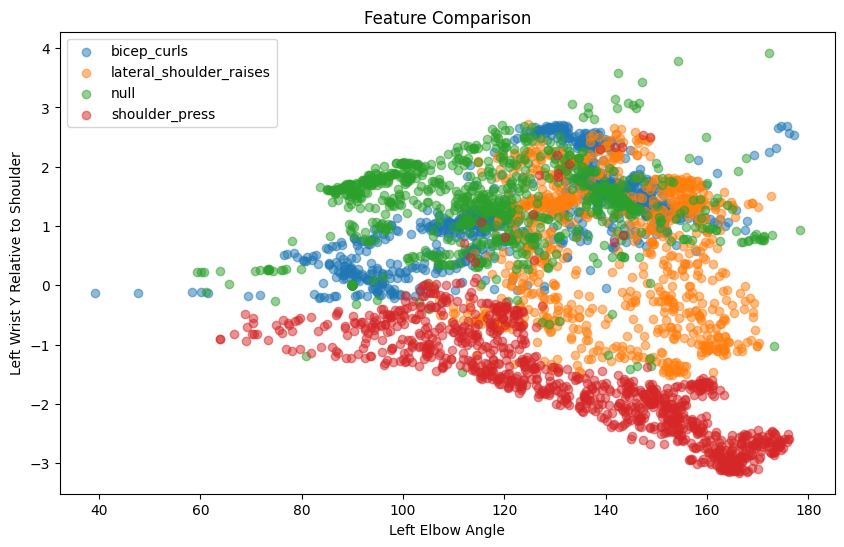

In [104]:
plt.figure(figsize=(10, 6))
for label, name in enumerate(directories):
    subset = df[df['label'] == label].sample(min(1000, len(df[df['label'] == label])))
    plt.scatter(subset['l_elbow_angle'], subset['l_wrist_y_rel'], label=name, alpha=0.5)

plt.xlabel('Left Elbow Angle')
plt.ylabel('Left Wrist Y Relative to Shoulder')
plt.title('Feature Comparison')
plt.legend()
plt.show()
# todo: maybe we need to delete outliers and invalid skeleton frames

In [105]:
print("\nframes per label:", df['label'].value_counts())
directories


frames per label: label
1    13180
0    12947
3     9627
2     7114
Name: count, dtype: int64


['bicep_curls', 'lateral_shoulder_raises', 'null', 'shoulder_press']

In [106]:
print("Subjects available:", df['subject'].unique())
print("Frames per subject:\n", df['subject'].value_counts())
print("\nLabels per subject:\n", df.groupby(['subject', 'label']).size())

Subjects available: ['w00' 'w01' 'w02' 'w17' 'w18' 'w19' 'w20']
Frames per subject:
 subject
w02    8000
w20    7376
w01    6614
w19    6047
w17    5284
w18    4857
w00    4690
Name: count, dtype: int64

Labels per subject:
 subject  label
w00      0        1427
         1        1269
         2         500
         3        1494
w01      0        1484
         1        2100
         2        1000
         3        2030
w02      0        1764
         1        2850
         2        2614
         3         772
w17      0        1739
         1        2003
         3        1542
w18      0        1653
         1        1809
         3        1395
w19      0        2527
         1         426
         2         700
         3        2394
w20      0        2353
         1        2723
         2        2300
dtype: int64


In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

train_subjects = ['w01', 'w02', 'w17' 'w18', 'w20']
test_subjects = ['w00', 'w19']

train_df = df[df['subject'].isin(train_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

X_train = train_df[['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel']]
y_train = train_df['label']

X_test = test_df[['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel']]
y_test = test_df['label']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6474806743038093

Confusion Matrix:
 [[1323    2 2629    0]
 [  69 1057  569    0]
 [ 192  157  851    0]
 [   0   32  135 3721]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.33      0.48      3954
           1       0.85      0.62      0.72      1695
           2       0.20      0.71      0.32      1200
           3       1.00      0.96      0.98      3888

    accuracy                           0.65     10737
   macro avg       0.72      0.66      0.62     10737
weighted avg       0.83      0.65      0.68     10737



In [108]:
print("\nframes per label:", df['label'].value_counts())
directories


frames per label: label
1    13180
0    12947
3     9627
2     7114
Name: count, dtype: int64


['bicep_curls', 'lateral_shoulder_raises', 'null', 'shoulder_press']

In [109]:
import sys
print(sys.executable)
print(sys.path)
import sklearn
print(sklearn.__version__)

/media/tony/hard/WorkoutHacker/ai/venv/bin/python
['/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python313.zip', '/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python3.13', '/home/linuxbrew/.linuxbrew/opt/python@3.13/lib/python3.13/lib-dynload', '', '/media/tony/hard/WorkoutHacker/ai/venv/lib/python3.13/site-packages']
1.8.0


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

train_subjects = ['w00', 'w01']
test_subjects = ['w02', 'w19']

train_df = df[df['subject'].isin(train_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

X_train = train_df[['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel']]
y_train = train_df['label']

X_test = test_df[['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel']]
y_test = test_df['label']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7253506086708906

Confusion Matrix:
 [[1977    0 2314    0]
 [  48 2407  773   48]
 [ 410  145 2674   85]
 [   0   35    0 3131]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59      4291
           1       0.93      0.73      0.82      3276
           2       0.46      0.81      0.59      3314
           3       0.96      0.99      0.97      3166

    accuracy                           0.73     14047
   macro avg       0.79      0.75      0.74     14047
weighted avg       0.79      0.73      0.73     14047



In [111]:
import joblib

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'exercise_classifier_rf.joblib')
joblib.dump(clf, model_filename)
print(f"Model saved to {model_filename}")


Model saved to ../models/exercise_classifier_rf.joblib


In [112]:
def predict_exercise(json_file_path, model):
    with open(json_file_path, 'r') as f:
        frames = json.load(f)
    
    skeleton_arr = skeleton_to_numpy(frames)
    normalized_arr = normalize_skeleton(skeleton_arr)
    
    features_list = []
    for i in range(len(normalized_arr)):
        features_list.append(extract_features_from_frame(normalized_arr[i]))
    
    X = pd.DataFrame(features_list, columns=['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel'])
    predictions = model.predict(X)
    
    # Majority vote for the whole clip
    final_prediction = np.bincount(predictions).argmax()
    label_map = {0: 'Bicep Curl', 1: 'Shoulder Press', 2: 'Null/Unknown'}
    
    return label_map[final_prediction], predictions

# Test on a file from bicep curls
test_file = os.path.join(bicep_curls_path, bicep_files[0])
prediction, frame_preds = predict_exercise(test_file, clf)
print(f"Prediction for {bicep_files[0]}: {prediction}")

# Test on a file from shoulder press
test_file_press = os.path.join(shoulder_press_path, press_files[0])
prediction_press, frame_preds_press = predict_exercise(test_file_press, clf)
print(f"Prediction for {press_files[0]}: {prediction_press}")

# Test on a file from null
test_file_null = os.path.join(null_path, null_files[0])
prediction_null, frame_preds_null = predict_exercise(test_file_null, clf)
print(f"Prediction for {null_files[0]}: {prediction_null}")

NameError: name 'bicep_curls_path' is not defined

In [ ]:
def smooth_skeleton(skeleton_arr, window_size=5):
    """
    Applies moving average smoothing to (num_frames, 33, 4) array
    """
    smoothed = skeleton_arr.copy()
    num_frames = skeleton_arr.shape[0]
    if num_frames < window_size:
        return smoothed
        
    for i in range(33): # Each landmark
        for j in range(3): # x, y, z
            smoothed[:, i, j] = pd.Series(skeleton_arr[:, i, j]).rolling(window=window_size, center=True, min_periods=1).mean()
            
    return smoothed

# Integrate smoothing into inference
def predict_exercise_smoothed(json_file_path, model):
    with open(json_file_path, 'r') as f:
        frames = json.load(f)
    
    skeleton_arr = skeleton_to_numpy(frames)
    smoothed_arr = smooth_skeleton(skeleton_arr)
    normalized_arr = normalize_skeleton(smoothed_arr)
    
    features_list = []
    for i in range(len(normalized_arr)):
        features_list.append(extract_features_from_frame(normalized_arr[i]))
    
    X = pd.DataFrame(features_list, columns=['l_elbow_angle', 'r_elbow_angle', 'l_shoulder_angle', 'r_shoulder_angle', 'l_wrist_y_rel', 'r_wrist_y_rel'])
    predictions = model.predict(X)
    
    final_prediction = np.bincount(predictions).argmax()
    label_map = {0: 'Bicep Curl', 1: 'Shoulder Press', 2: 'Null/Unknown'}
    
    return label_map[final_prediction]

print("Smoothed Prediction (Bicep):", predict_exercise_smoothed(os.path.join(bicep_curls_path, bicep_files[0]), clf))

Smoothed Prediction (Bicep): Null/Unknown
